# Example: Fitting a waveform with summed multipoles

In [1]:
from jaxqualin.waveforms import get_SXS_waveform_summed
from jaxqualin.qnmode import mode_list
from jaxqualin.fit import QNMFitVaryingStartingTime
from jaxqualin.plot import (plot_amplitudes, plot_phases, 
                            plot_omega_free, plot_predicted_qnms)

import numpy as np
import matplotlib.pyplot as plt

### Make waveform

We will use a waveform that is a superposition of multipoles (up to `l_max = 4`) of the `SXS:BBH:0305` simulation.
The observer is at the angular coordinate $(\iota, \psi)$. 

In [2]:
SXSnum = '0305'
iota = np.pi/3 # Cotesta's angle
psi = np.pi/2
h, Mf, af = get_SXS_waveform_summed(SXSnum, iota, psi, l_max=4, res=0, N_ext=2)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


Text(0, 0.5, '$|h_r|$')

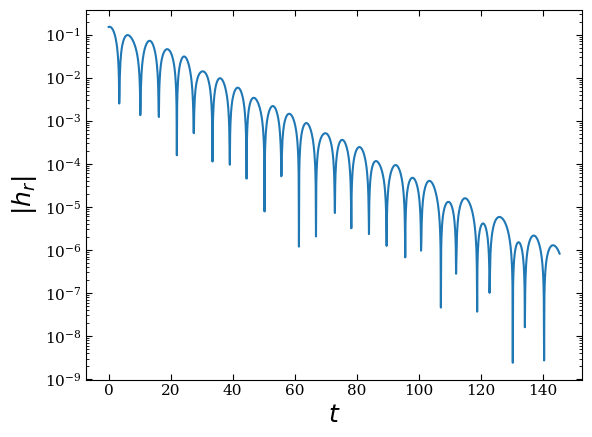

In [3]:
fig, ax = plt.subplots()
ax.semilogy(h.time, np.abs(h.hr))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$|h_r|$')

### Free QNMs (unfixed frequencies)

In [4]:
t0_arr = np.linspace(0, 50, num = 101) # array of starting times to fit for
                                       # t0 = 0 is the peak of the strain
qnm_fixed_list = [] # list of QNMs with fixed frequencies in the fit model
run_string_prefix = f"SXS{SXSnum}_lm_2.2_iota_{iota:.7f}_psi_{psi:.7f}" # prefix of pickle file for saving the results
N_free = 6 # number of free modes to use

# fitter object
fitter = QNMFitVaryingStartingTime(
                            h, t0_arr, N_free = N_free,
                            qnm_fixed_list = qnm_fixed_list, load_pickle = True,
                            run_string_prefix = run_string_prefix)

In [5]:
# do fits, in series from lowest to highest starting time
# This takes a little longer to run the first time
fitter.do_fits()

Runname: SXS0305_lm_2.2_iota_1.0471976_psi_1.5707963, fitting for N_free = 6. Status:   0%|          | 0/101 […

In [6]:
# fitter results object
result = fitter.result_full

#### Plotting the results
We will see some of the mirror modes (modes with negative $m$) because we summed all of the multipoles

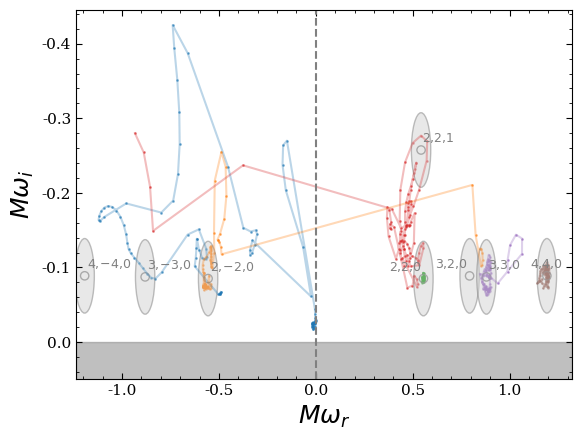

In [7]:
fig, ax = plt.subplots()

# mode locations to visualize on the plot
predicted_qnms = mode_list(['2.2.0', '2.2.1', '3.2.0', '3.3.0',
                            '2.-2.0', '3.-3.0', '4.-4.0', '4.4.0'], Mf, af)

plot_omega_free(result, ax)
plot_predicted_qnms(ax, predicted_qnms)

### Fixed QNMs (fixed frequencies)
Let us assume that the $2{,}2{,}0, 3{,}3{,}0, 4{,}4{,}0$ modes and their mirror counter-parts exist in the waveform

In [8]:
t0_arr = np.linspace(0, 50, num = 101) # array of starting times to fit for
                                       # t0 = 0 is the peak of the straisn
qnm_fixed_list = mode_list(['2.2.0', '2.-2.0', '3.3.0', 
                            '3.-3.0', '4.4.0', '4.-4.0'], 
                            Mf, af) # list of QNMs with fixed frequencies in the fit model
run_string_prefix = f"SXS{SXSnum}_lm_2.2_iota_{iota:.7f}_psi_{psi:.7f}" # prefix of pickle file for saving the results
N_free = 0 # number of free modes to use

# fitter object
fitter = QNMFitVaryingStartingTime(
                            h, t0_arr, N_free = N_free,
                            qnm_fixed_list = qnm_fixed_list, load_pickle = True,
                            run_string_prefix = run_string_prefix)

In [9]:
fitter.do_fits()
result = fitter.result_full

Runname: SXS0305_lm_2.2_iota_1.0471976_psi_1.5707963, fitting with the following modes: 2.2.0, 2.-2.0, 3.3.0, …

#### Plotting the results
Because our waveform is non-precessing, by PT symmetry, the amplitudes of the mirror modes can be predicted from those of the prograde modes, i.e.
$$
\tilde{A}_{\ell{,}-m{,}n} = \dfrac{S_{\ell{,}-m{,}n}(\iota, \psi)}{S_{\ell{,}m{,}n}^*(\iota, \psi)}\tilde{A}^*_{\ell{,}m{,}n} ,
$$
Where $\tilde{A}$ denotes the complex amplitude, and $S_{\ell{,}m{,}n}$ are the spin weighted ($s = -2$ in this case) spheroidal harmonics.
We compute the predicted mirror mode amplitudes and plot them as dashed lines with colors corresponding to their prograde mode counter-parts.

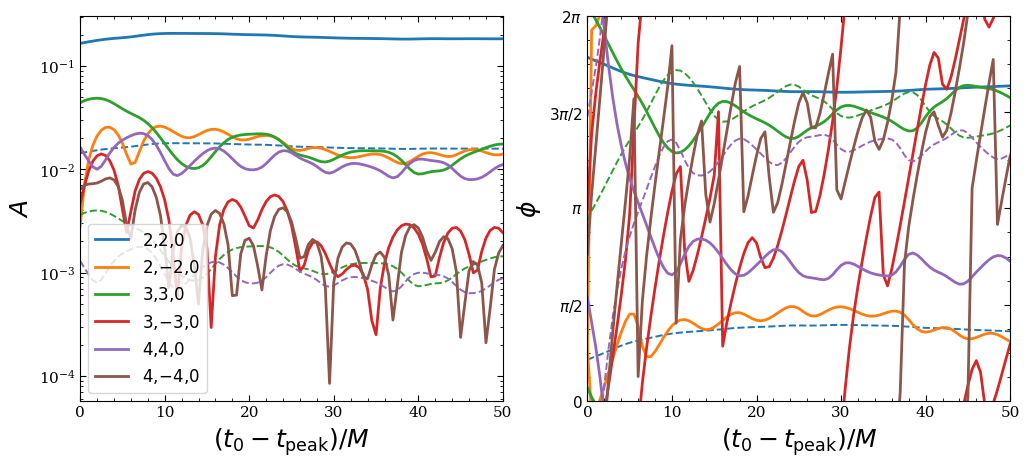

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
plot_amplitudes(result, fixed_modes = qnm_fixed_list, ax = axs[0], 
                plot_mirror_pred = True, iota = iota, psi = psi, af = af)
plot_phases(result, fixed_modes = qnm_fixed_list, ax = axs[1], 
            legend = False, plot_mirror_pred = True, 
            iota = iota, psi = psi, af = af)

### Including a pair of prograde and mirror modes as the same mode
Given the relationship between the complex amplitudes of the prograde and mirror modes for non-precessing mergers, we can include both modes as one mode into our fit model. 
This can be done with `include_mirror = True`.

In [11]:
t0_arr = np.linspace(0, 50, num = 101) 
qnm_fixed_list = mode_list(['2.2.0', '3.3.0', '4.4.0'], Mf, af)
run_string_prefix = f"SXS{SXSnum}_lm_2.2_iota_{iota:.7f}_psi_{psi:.7f}_incl_mirror"
N_free = 0

fitter = QNMFitVaryingStartingTime(
                            h, t0_arr, N_free = N_free,
                            qnm_fixed_list = qnm_fixed_list, load_pickle = False,
                            run_string_prefix = run_string_prefix,
                            include_mirror = True, iota = iota, psi = psi)

In [12]:
fitter.do_fits()
result = fitter.result_full

Runname: SXS0305_lm_2.2_iota_1.0471976_psi_1.5707963_incl_mirror, fitting with the following modes: 2.2.0, 3.3…

#### Plotting the results
Only the amplitude of the prograde modes are shown, but the mirror modes have been included in the fit, with amplitudes fixed by PT symmetry as explained above.

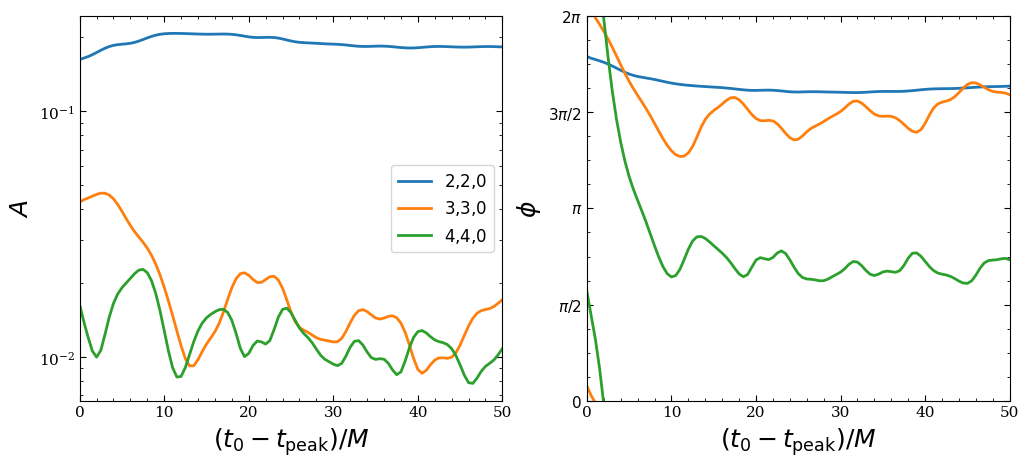

In [13]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
plot_amplitudes(result, fixed_modes = qnm_fixed_list, ax = axs[0], plot_mirror_pred = False)
plot_phases(result, fixed_modes = qnm_fixed_list, ax = axs[1], legend = False, plot_mirror_pred = False)